# Práctica Calificada 2 - Grupo 1
---
<h3>1. OBJETIVO</h3>

**Predicción de tarifas de taxis**<br>
El objetivo de esta evaluación es construir un modelo de aprendizaje que sea capaz de
predecir la tarifa que cobra un taxi de acuerdo a cierta información de entrada.

<h3>2. PAQUETES Y MÓDULOS</h3>

In [96]:
import warnings
warnings.filterwarnings("ignore")

In [97]:
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, average_precision_score, precision_recall_curve
from inspect import signature
from math import sqrt, sin, cos, asin, pi, log
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

import plotly.express as px
import pandas as pd
import numpy as np
import seaborn as sns
import datetime as dt
import os
import matplotlib.pyplot as plt
import ciso8601 #módulo que contiene una implementacion rapida de datetime

%matplotlib inline

<h3>3. MUESTREO</h3>

El conjunto de datos está compuesto por un archivo CSV que contiene alrededor de 55
millones de registros de viajes en taxi. Cada registro contiene la siguiente información:
* **ID**: cadena que identifica de manera única a cada registro
* **pickup_datetime**: timestamp indicando cuando el viaje a empezado
* **pickup_longitude**: número real indicando la ubicación en **longitud** en donde el viaje
empezó
* **pickup_latitude**: número real indicando la ubicación en **latitud** en donde el viaje
empezó
* **dropoff_longitude**: número real indicando la ubicación en longitud en donde el viaje
terminó
* **dropoff_latitude**: número real indicando la ubicación en latitud en donde el viaje
terminó
* **passenger_count**: número entero indicando el número de pasajeros en el servicio de
taxi
* **fare_amount: número real indicando el costo del taxi. Esta es la variable a predecir**

**Población**

In [98]:
%%time
df = pd.read_csv("1M_train.csv")
df.shape

CPU times: user 1.85 s, sys: 50.9 ms, total: 1.9 s
Wall time: 2.3 s


(1000000, 8)

**Muestra**

In [99]:
%%time
df_s = df.sample(50000, random_state = 7, replace = True)
#df_s = df
#df_s.shape

CPU times: user 28.7 ms, sys: 0 ns, total: 28.7 ms
Wall time: 32.9 ms


In [100]:
df_s.head()

key  fare_amount          pickup_datetime  \
585903   2010-12-17 23:43:00.00000013          7.7  2010-12-17 23:43:00 UTC   
189636  2011-05-16 17:46:00.000000216         17.7  2011-05-16 17:46:00 UTC   
573977   2009-03-20 04:12:00.00000029         13.3  2009-03-20 04:12:00 UTC   
535030   2014-10-21 12:07:00.00000070          7.5  2014-10-21 12:07:00 UTC   
759363    2009-08-09 14:04:19.0000003          6.5  2009-08-09 14:04:19 UTC   

        pickup_longitude  pickup_latitude  dropoff_longitude  \
585903        -73.981623        40.778652         -73.953005   
189636        -73.987248        40.720307         -73.979720   
573977        -73.988588        40.764103         -73.990217   
535030        -73.986547        40.743327         -73.985617   
759363        -73.989920        40.733406         -73.976019   

        dropoff_latitude  passenger_count  
585903         40.783392                2  
189636         40.674560                1  
573977         40.714545                5  
535030         40.754775                1  
759363         40.754589                1

In [101]:
df_s.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 585903 to 300702
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   key                50000 non-null  object 
 1   fare_amount        50000 non-null  float64
 2   pickup_datetime    50000 non-null  object 
 3   pickup_longitude   50000 non-null  float64
 4   pickup_latitude    50000 non-null  float64
 5   dropoff_longitude  50000 non-null  float64
 6   dropoff_latitude   50000 non-null  float64
 7   passenger_count    50000 non-null  int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 3.4+ MB


<h3>4.LIMPIEZA</h3>

**ELIMINAR NA Y COLUMNA KEY**

In [102]:
df_s.isna().sum() # pandas.DataFrame.isna() vs pandas.DataFrame.isnull(), these two DataFrame methods do exactly the same thing! 

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

In [103]:
df_s.dropna(inplace=True)

In [104]:
df_s.isna().sum()

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

In [105]:
df_s.shape

(50000, 8)

In [106]:
df_s.drop(columns='key', inplace=True)

**DETERMINAR NÚMERO DE PASAJEROS VALIDOS**

Descripción de la columna número de pasajeros (**passenger_count**)

In [107]:
df_s.passenger_count.describe()

count    50000.000000
mean         1.678080
std          1.304363
min          0.000000
25%          1.000000
50%          1.000000
75%          2.000000
max          6.000000
Name: passenger_count, dtype: float64

Visualizando **la cantidad de viajes en taxi por el número de pasajeros**

Text(0.5, 1.0, 'Cantidad de viajes en taxi por número de pasajeros')

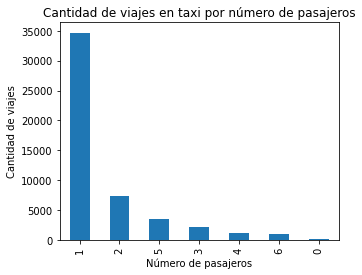

In [108]:
df_s["passenger_count"].value_counts().plot(kind="bar", figsize=(5, 4))
plt.xlabel("Número de pasajeros")
plt.ylabel("Cantidad de viajes")
plt.title("Cantidad de viajes en taxi por número de pasajeros")

Filtramos :  $ ~~1\leq \text{passenger_count}\leq6$

In [109]:
df_s["passenger_count"].between(1,6).value_counts() # Return boolean Series equivalent to left <= series <= right.

True     49802
False      198
Name: passenger_count, dtype: int64

**DETERMINAR TARIFA DEL VIAJE VALIDA**

Descripción de la columna monto de la tarifa (**fare_amount**)

In [110]:
df_s.fare_amount.describe()

count    50000.000000
mean        11.345612
std          9.930443
min        -20.000000
25%          6.000000
50%          8.500000
75%         12.500000
max        250.000000
Name: fare_amount, dtype: float64

Text(0.5, 1.0, 'Frecuencia de las tarifas de los viajes en intervalos (k,5+k], $k=0,5,10,...}$')

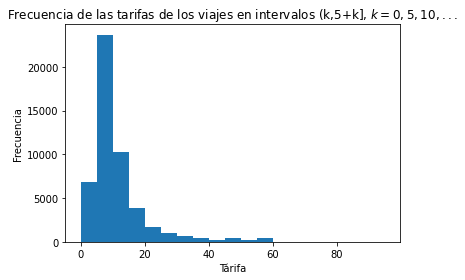

In [111]:
df_s["fare_amount"].plot.hist(alpha=1, stacked=True, bins=list(range(0, 100, 5)))
plt.xlabel("Tárifa")
plt.ylabel("Frecuencia")
plt.title("Frecuencia de las tarifas de los viajes en intervalos (k,5+k], $k=0,5,10,...}$")

Filtramos :  $~~2\leq \text{fare_amount}\leq 200$

In [112]:
df_s[(df_s['fare_amount'] < 0)].shape # negativos

(1, 7)

In [113]:
df_s[(df_s['fare_amount'] > 0) & (df_s['fare_amount'] < 2)].shape # mayor a cero y menor a dos

(1, 7)

In [114]:
df_s[(df_s['fare_amount'] > 200)].shape # mayores a 200

(5, 7)

In [115]:
df_s["fare_amount"].between(2,200).value_counts()

True     49993
False        7
Name: fare_amount, dtype: int64

**DETERMINAR REGIÓN VALIDA**

In [116]:
fig = px.scatter_mapbox(df_s, lat="pickup_latitude", lon="pickup_longitude",
                        color_discrete_sequence=["green"], zoom=6, height=400)
#fig = px.scatter_mapbox(df_s[:1000], lat="pickup_latitude", lon="pickup_longitude", color_discrete='fare_amount', zoom=5, height=300)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

Mostrando los puntos en el mapa se encuentra que la región de validación es New York, a partir de ahora vamos a considerar ello.

**LIMPIEZA  GENERAL**

In [117]:
%%time
def filter_data(dataframe):
    #Solo quedan si cumplen las condiciones 
    return dataframe[
        #Coordenadas Ilegales
        (-180.0 <= dataframe["pickup_longitude"])&
        (dataframe["pickup_longitude"] <= 180.0)&
        (-90.0 <= dataframe["pickup_latitude"])&
        (dataframe["pickup_latitude"] <= 90.0)&
        (-180.0 <= dataframe["dropoff_longitude"])&
        (dataframe["dropoff_longitude"] <= 180.0)&
        (-90.0 <= dataframe["dropoff_latitude"])&
        (dataframe["dropoff_latitude"] <= 90.0)& 
        #(df_s["pickup_longitude"] != df_s["dropoff_longitude"])&
        #Fare amount  
        (2.0 <= dataframe["fare_amount"])&
        (dataframe["fare_amount"] <= 100)&
        # passenger_count
        (1<=dataframe["passenger_count"])&
        (dataframe["passenger_count"]<= 6)]    
     
print ("Shape antes del limpieza general: ", df_s.shape)
data = filter_data(df_s)
print ("Shape despues del limpieza general: ", data.shape)
print ("Limpiando %d registros"%(df_s.shape[0] - data.shape[0]))

Shape antes del limpieza general:  (50000, 7)
Shape despues del limpieza general:  (49784, 7)
Limpiando 216 registros
CPU times: user 19.9 ms, sys: 0 ns, total: 19.9 ms
Wall time: 37.2 ms


**INTERCAMBIAR COORDENADAS DE PUNTOS PARA CONSIDERARLOS DENTRO DE LA REGIÓN VALIDA**

In [118]:
def swap_coordinates (dataframe,
    city_limits = { 
        "lon_min":-76,
        "lon_max":-73,
        "lat_min":38,
        "lat_max":50} ):
    #Intercambia las coordenadas de los viajes en 
    # la region [38 , 50]x[-76, -73]
    # la region de principarl de trabajo
    # (cuidad de NY) es : [-76, -73]x[38 , 50]
    datap = dataframe
    city_interchange = (
        (datap["pickup_longitude"] > city_limits["lat_min"])&
        (datap["pickup_longitude"] < city_limits["lat_max"])&
        (datap["pickup_latitude"] > city_limits["lon_min"] )& #-74.252444 
        (datap["pickup_latitude"] < city_limits["lon_max"] )& 

        (datap["dropoff_longitude"] > city_limits["lat_min"])&
        (datap["dropoff_longitude"] < city_limits["lat_max"])&
        (datap["dropoff_latitude"] >  city_limits["lon_min"] )&
        (datap["dropoff_latitude"] <  city_limits["lon_max"] ) 
        )
    print ( "Numero de reflejos : ",city_interchange.sum())
    
    datap.loc[city_interchange] = datap.loc[city_interchange].rename(columns={
        'pickup_longitude':'pickup_latitude',
        'pickup_latitude':'pickup_longitude',
        'dropoff_latitude':'dropoff_longitude',
        'dropoff_longitude':'dropoff_latitude'})
    return datap

data = swap_coordinates(data)


Numero de reflejos :  28


**DETERMINAR LA REGIÓN VALIDA**

In [119]:
#long_border = (-74.03, -73.75)
#lat_border = (40.63, 40.85)
def filter_out_of_city(dataframe,city_limits = { 
        "lon_min":-74.03 ,
        "lon_max":-73.75,
        "lat_min":40.63,
        "lat_max":40.85}):
    #Solo quedan si estan dentro de la ciudad 
    return dataframe[
        (city_limits["lon_min"]<= dataframe["pickup_longitude"])&
        (dataframe["pickup_longitude"] <= city_limits["lon_max"])&
        (city_limits["lat_min"]<= dataframe["pickup_latitude"])&
        (dataframe["pickup_latitude"] <= city_limits["lat_max"])&
        (city_limits["lon_min"] <= dataframe["dropoff_longitude"])&
        (dataframe["dropoff_longitude"] <= city_limits["lon_max"])&
        (city_limits["lat_min"]<= dataframe["dropoff_latitude"])&
        (dataframe["dropoff_latitude"] <= city_limits["lat_max"])]

print ("Shape antes de la limpieza por región: ", data.shape)
data = filter_out_of_city(data)
print ("Shape despues de la limpieza por región: ", data.shape)
print ("Limpiando %d registros acumulados en total hasta ahora "%(df_s.shape[0] - data.shape[0]))

Shape antes de la limpieza por región:  (49784, 7)
Shape despues de la limpieza por región:  (48157, 7)
Limpiando 1843 registros acumulados en total hasta ahora 


In [120]:
data.head()

fare_amount          pickup_datetime  pickup_longitude  \
585903          7.7  2010-12-17 23:43:00 UTC        -73.981623   
189636         17.7  2011-05-16 17:46:00 UTC        -73.987248   
573977         13.3  2009-03-20 04:12:00 UTC        -73.988588   
535030          7.5  2014-10-21 12:07:00 UTC        -73.986547   
759363          6.5  2009-08-09 14:04:19 UTC        -73.989920   

        pickup_latitude  dropoff_longitude  dropoff_latitude  passenger_count  
585903        40.778652         -73.953005         40.783392                2  
189636        40.720307         -73.979720         40.674560                1  
573977        40.764103         -73.990217         40.714545                5  
535030        40.743327         -73.985617         40.754775                1  
759363        40.733406         -73.976019         40.754589                1

**EXPLORACIÓN DE TARIFAS POR AEROPUERTO**

In [121]:
fig = px.scatter_mapbox(data[data["fare_amount"]<60], lat="pickup_latitude", lon="pickup_longitude",
                        color='fare_amount', zoom=6, height=300)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

Se explora algún patrón que relacione la variabilidad de la tarifa con ciertas regiones de New York, encontrando que en los tres aeropuertos de New York, los cuales son **John F. Kennedy Airport** (JFK), **LaGuardia** (LGA) y **Newark Airport** (EWR), las tarifas son elevadas respecto al resto de regiones, porque se concentra la mayor cantidad de tarifas de mayor precio en esas zonas (Para una mejor visualización por ejemplo hacer zoom en los aeropuertos JFK, encontrandose puntos de color amarillo que representan tarifas elevadas).
<img src="JFK.png" width = "300">

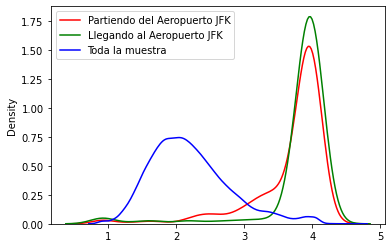

In [122]:
# JFK : Aeropuerto Jhon F. Kennedy
JFK={'min_long':-73.8352,'min_lat':40.6195,'max_long':-73.7401, 'max_lat':40.6659}

pickup_JFK=data.loc[(data.pickup_latitude>=JFK['min_lat']) & (data.pickup_latitude<=JFK['max_lat'])&
                   (data.pickup_longitude>=JFK['min_long']) & (data.pickup_longitude<=JFK['max_long'])]

dropoff_JFK=data.loc[(data.dropoff_latitude>=JFK['min_lat']) & (data.dropoff_latitude<=JFK['max_lat']) & 
                    (data.dropoff_longitude>=JFK['min_long']) & (data.dropoff_longitude<=JFK['max_long'])]

plt.figure(figsize=(6,4))
sns.kdeplot(np.log(pickup_JFK['fare_amount'].values),label='Partiendo del Aeropuerto JFK', color="red")
sns.kdeplot(np.log(dropoff_JFK['fare_amount'].values),label='Llegando al Aeropuerto JFK', color="green")
sns.kdeplot(np.log(data['fare_amount'].values),label='Toda la muestra', color="blue")
plt.legend()

Se visualiza que la distribución de grandes tarifas se encuentra concentranda en la zona del aeropuerto JFK, ya sea partiendiendo o llegando a esa zona, analogamente para los otros aeropuertos.

EWR : Partiendo 0 - LLegando 0


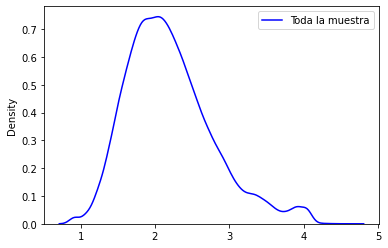

In [123]:
# EWR : Aeropuerto Internacional Libertad de Newark
EWR={'min_long':-74.1925,'min_lat':40.6700, 'max_long':-74.1531, 'max_lat':40.7081}

pickup_EWR=data.loc[ (data.pickup_latitude>=EWR['min_lat']) & (data.pickup_latitude<=EWR['max_lat'])&
                     (data.pickup_longitude>=EWR['min_long']) & (data.pickup_longitude<=EWR['max_long'])]

dropoff_EWR=data.loc[ (data.dropoff_latitude>=EWR['min_lat']) & (data.dropoff_latitude<=EWR['max_lat'])&
                      (data.dropoff_longitude>=EWR['min_long']) & (data.dropoff_longitude<=EWR['max_long'])]
                    
print("EWR : Partiendo %d - LLegando %d"%(pickup_EWR.shape[0],dropoff_EWR.shape[0]))

plt.figure(figsize=(6,4))
sns.kdeplot(np.log(pickup_EWR['fare_amount'].values),label='Partiendo del Aeropuerto JFK', color="red")
sns.kdeplot(np.log(dropoff_EWR['fare_amount'].values),label='Llegando al Aeropuerto JFK', color="green")
sns.kdeplot(np.log(data['fare_amount'].values),label='Toda la muestra', color="blue")
plt.legend()

LG : Partiendo 932 - LLegando 647


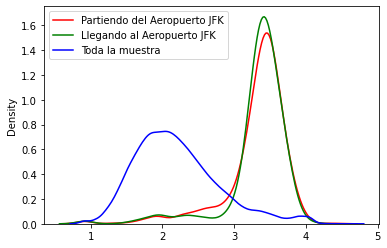

In [124]:
#LG : Aeropuerto Internacional de La Guardia
LG={'min_long':-73.8895, 'min_lat':40.7664,'max_long':-73.8550,'max_lat':40.7931}

pickup_LG=data.loc[(data.pickup_latitude>=LG['min_lat']) & (data.pickup_latitude<=LG['max_lat'])&
                  (data.pickup_longitude>=LG['min_long']) & (data.pickup_longitude<=LG['max_long'])]

dropoff_LG=data.loc[(data.dropoff_latitude>=LG['min_lat']) & (data.dropoff_latitude<=LG['max_lat'])&
                   (data.dropoff_longitude>=LG['min_long']) & (data.dropoff_longitude<=LG['max_long'])]
print("LG : Partiendo %d - LLegando %d"%(pickup_LG.shape[0],dropoff_LG.shape[0]))

plt.figure(figsize=(6,4))
sns.kdeplot(np.log(pickup_LG['fare_amount'].values),label='Partiendo del Aeropuerto JFK', color="red")
sns.kdeplot(np.log(dropoff_LG['fare_amount'].values),label='Llegando al Aeropuerto JFK', color="green")
sns.kdeplot(np.log(data['fare_amount'].values),label='Toda la muestra', color="blue")
plt.legend()

<h2>5. INGENIERÍA DE CARACTERÍSTICAS</h2>

**CONTROL DE VIAJES PARTIENDO O LLEGANDO A LOS AEROPUERTOS DE NEW YORK**

In [125]:
def atJFK(lat,long):
    if (lat >= JFK['min_lat'] and lat <= JFK['max_lat'] and  
        long >= JFK['min_long'] and long <= JFK['max_long']):
        return 1
    return 0

In [126]:
def atEWR(lat,long):
    if (lat >= EWR['min_lat'] and lat <= EWR['max_lat'] and  
        long >= EWR['min_long'] and long <= EWR['max_long']):
        return 1
    return 0

In [127]:
def atLG(lat,long):
    if (lat >= LG['min_lat'] and lat <= LG['max_lat'] and  
        long >= LG['min_long'] and long <= LG['max_long']):
        return 1
    return 0

def atAirport(lat,long):
    if (atLG(lat,long) == 1 | atJFK(lat,long) == 1 | atEWR(lat,long)) : 
        return 1
    return 0

data['pickup_airport'] = data.apply(lambda row: atAirport(row['pickup_latitude'],row['pickup_longitude']),axis=1)
data['dropoff_airport'] = data.apply(lambda row: atAirport(row['dropoff_latitude'],row['dropoff_longitude']),axis=1)

In [128]:
data[(data['pickup_airport'] == 1)].head()

fare_amount          pickup_datetime  pickup_longitude  \
784938        28.90  2011-02-08 15:08:59 UTC        -73.862692   
750395        21.50  2014-09-17 21:59:57 UTC        -73.870767   
874894        40.33  2013-08-15 12:11:24 UTC        -73.865580   
211697        28.90  2012-04-17 10:35:30 UTC        -73.874428   
411264        21.70  2011-11-29 22:57:00 UTC        -73.870628   

        pickup_latitude  dropoff_longitude  dropoff_latitude  passenger_count  \
784938        40.769260         -73.984668         40.758440                1   
750395        40.773701         -73.963059         40.762427                1   
874894        40.769740         -73.978616         40.762442                1   
211697        40.774070         -74.012675         40.701977                1   
411264        40.773695         -73.983412         40.722043                1   

        pickup_airport  dropoff_airport  
784938               1                0  
750395               1                0  
874894               1                0  
211697               1                0  
411264               1                0

<h5>SEPARAR DATETIME EN YEAR, MONTH, DAY, HOUR Y WEEKDAY</h5>

In [129]:
%%time
def f2(datestr):
    return ciso8601.parse_datetime(datestr [ :-4])

def separate_datetime_to_features(dataframe): 
    dataframe ['pickup_datetime'] =dataframe.pickup_datetime.apply(f2)  #pd.to_datetime(data.pickup_datetime ,infer_datetime_format=True) # convertimos a tipo de dato de datetime
    dataframe['year'] = dataframe['pickup_datetime'].dt.year
    dataframe['month'] = dataframe['pickup_datetime'].dt.month
    dataframe['day'] = dataframe['pickup_datetime'].dt.day
    dataframe['hour'] = dataframe['pickup_datetime'].dt.hour
    dataframe['weekday'] = dataframe['pickup_datetime'].dt.weekday
    dataframe.drop(columns='pickup_datetime', inplace=True)
    return dataframe
data = separate_datetime_to_features(data)

CPU times: user 108 ms, sys: 178 µs, total: 108 ms
Wall time: 130 ms


In [130]:
data.head()

fare_amount  pickup_longitude  pickup_latitude  dropoff_longitude  \
585903          7.7        -73.981623        40.778652         -73.953005   
189636         17.7        -73.987248        40.720307         -73.979720   
573977         13.3        -73.988588        40.764103         -73.990217   
535030          7.5        -73.986547        40.743327         -73.985617   
759363          6.5        -73.989920        40.733406         -73.976019   

        dropoff_latitude  passenger_count  pickup_airport  dropoff_airport  \
585903         40.783392                2               0                0   
189636         40.674560                1               0                0   
573977         40.714545                5               0                0   
535030         40.754775                1               0                0   
759363         40.754589                1               0                0   

        year  month  day  hour  weekday  
585903  2010     12   17    23        4  
189636  2011      5   16    17        0  
573977  2009      3   20     4        4  
535030  2014     10   21    12        1  
759363  2009      8    9    14        6

<h5>DETERMINAR LA DISTANCIA DE HAVERSINE ENTRE PUNTOS DADO SU LATITUD Y LONGITUD</h5>

In [131]:
%time
def haversine(lon1, lat1, lon2, lat2):
    # Haversine vectorizado usando funciones de np
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    km[km < 0.00008] = 0.00008
    return km
    #print(Haversine(39.50, 98.35, 48.8567, 2.3508))

data['distance'] = haversine(data['pickup_longitude'],data['pickup_latitude'] , data['dropoff_longitude'], data['dropoff_latitude'])
data.describe()

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.39 µs


fare_amount  pickup_longitude  pickup_latitude  dropoff_longitude  \
count  48157.000000      48157.000000     48157.000000       48157.000000   
mean      10.994936        -73.975496        40.751042         -73.974670   
std        8.772103          0.033441         0.026234           0.031718   
min        2.500000        -74.029620        40.631263         -74.029747   
25%        6.000000        -73.992010        40.736619         -73.991562   
50%        8.500000        -73.982053        40.753492         -73.980717   
75%       12.500000        -73.968143        40.767577         -73.965570   
max      100.000000        -73.755697        40.849600         -73.754235   

       dropoff_latitude  passenger_count  pickup_airport  dropoff_airport  \
count      48157.000000     48157.000000    48157.000000     48157.000000   
mean          40.751248         1.686546        0.019353         0.013435   
std            0.028448         1.304208        0.137765         0.115130   
min           40.630195         1.000000        0.000000         0.000000   
25%           40.735900         1.000000        0.000000         0.000000   
50%           40.753865         1.000000        0.000000         0.000000   
75%           40.768364         2.000000        0.000000         0.000000   
max           40.849977         6.000000        1.000000         1.000000   

               year         month           day          hour       weekday  \
count  48157.000000  48157.000000  48157.000000  48157.000000  48157.000000   
mean    2011.744149      6.277031     15.746807     13.527296      3.025313   
std        1.867244      3.436002      8.690390      6.520673      1.952804   
min     2009.000000      1.000000      1.000000      0.000000      0.000000   
25%     2010.000000      3.000000      8.000000      9.000000      1.000000   
50%     2012.000000      6.000000     16.000000     14.000000      3.000000   
75%     2013.000000      9.000000     23.000000     19.000000      5.000000   
max     2015.000000     12.000000     31.000000     23.000000      6.000000   

           distance  
count  48157.000000  
mean       3.199739  
std        3.371030  
min        0.000080  
25%        1.244829  
50%        2.127872  
75%        3.840815  
max       26.005145

**TARIFA PROMEDIO POR HORA**<br>
Se observa una mayor tarifa a las 4am y 5am.

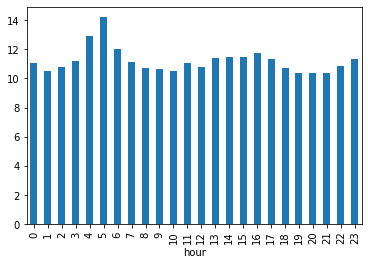

In [132]:
data.groupby(["hour"]).fare_amount.mean().plot.bar(x='hour',y='fare_amount')
plt.show()

**TARIFA PROMEDIO POR AÑO**<br>
Se observa un crecimiento de la tarifa en promedio cada año

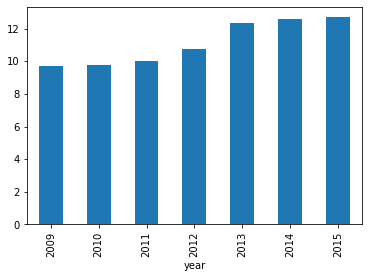

In [133]:
data.groupby(["year"]).fare_amount.mean().plot.bar(x='year',y='fare_amount')
plt.show()

**TARIFA PROMEDIO POR DÍA DE LA SEMANA**<br>

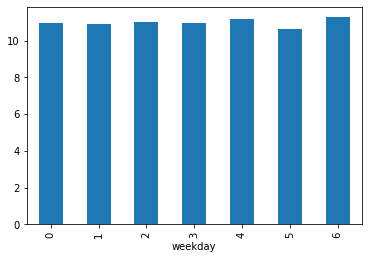

In [134]:
data.groupby(["weekday"]).fare_amount.mean().plot.bar(x='weekday',y='fare_amount')
plt.show()

**TARIFA PROMEDIO POR MES**<br>

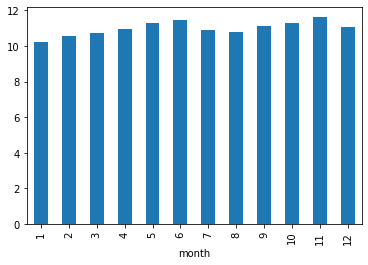

In [135]:
data.groupby(["month"]).fare_amount.mean().plot.bar(x='month',y='fare_amount')
plt.show()

**Matriz de Correlación**

In [136]:
data['airport'] =  data['pickup_airport'] + data['dropoff_airport']
data.drop(columns=['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','pickup_airport','dropoff_airport'], inplace=True)

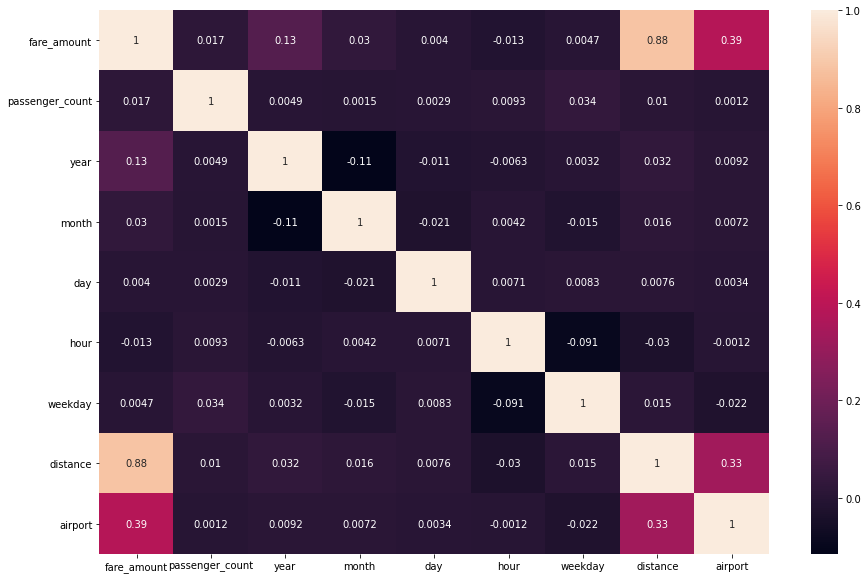

CPU times: user 747 ms, sys: 54.9 ms, total: 802 ms
Wall time: 987 ms


In [137]:
%%time
fig, ax = plt.subplots(figsize = (15, 10))
sns.heatmap(data.corr(), annot=True, ax=ax)
plt.show()

0.4 y 0.88 entre fare_amount y airport, y fare_amount y distance.